# Gastrointestinal disease Detection and classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
tf.config.list_physical_devices(
    device_type=None
)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import warnings
import random

# warnings.filterwarnings("ignore")



In [5]:
# Removed deprecated TensorFlow logging settings
dataset_path = "unsplit-dataset"

image_size = (224, 224)
batch_size = 64
# Load datasets
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,
    subset="training",
    label_mode="categorical",
    seed=23,
    image_size=image_size,
    batch_size=batch_size)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,
    subset="validation",
    label_mode="categorical",
    seed=23,
    image_size=image_size,
    batch_size=batch_size)

class_names = train_ds.class_names



Found 8000 files belonging to 8 classes.
Using 4800 files for training.
Found 8000 files belonging to 8 classes.
Using 3200 files for validation.


In [6]:
# Split validation dataset into validation and test sets
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [29]:
# Optimize dataset loading with prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [30]:
# Build the model
model = Sequential()
base_model = tf.keras.applications.ResNet101V2(
    include_top=False,
    weights="imagenet",
    pooling='max',
    classifier_activation="softmax",  # Changed to None for logits output
)

In [31]:
# Set base model to trainable
for layer in base_model.layers:
        layer.trainable=True

model.add(base_model)
model.add(Flatten())
# model.add(Dense(512, activation='relu'))  # Added a dense layer for feature extraction
model.add(Dense(8, activation='softmax'))

In [32]:
# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [33]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 2048)                │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │          16,392 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,642,952 (162.67 MB)

 Trainable params: 42,545,288 (162.30 MB)

 Non-trainable params: 97,664 (381.50 KB)

In [34]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
best = ModelCheckpoint(filepath="/content/drive/MyDrive/Dataset/best/model_best_val_accuracy.weights.h5",
                        save_weights_only=True, monitor="val_accuracy", mode="max", save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [35]:
# Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[reduce_lr, best])

# Save the model
model.save("finalwithhighaccuracy.h5")

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.5755 - loss: 3.2977 - precision: 0.5840 - recall: 0.5582 - val_accuracy: 0.1538 - val_loss: 26.2155 - val_precision: 0.1539 - val_recall: 0.1538 - learning_rate: 0.0010
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.8211 - loss: 0.5019 - precision: 0.8390 - recall: 0.8093 - val_accuracy: 0.5544 - val_loss: 2.6964 - val_precision: 0.5578 - val_recall: 0.5462 - learning_rate: 0.0010
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8687 - loss: 0.3440 - precision: 0.8737 - recall: 0.8616 - val_accuracy: 0.6756 - val_loss: 1.4042 - val_precision: 0.6789 - val_recall: 0.6687 - learning_rate: 0.0010
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8920 - loss: 0.2612 - precision: 0.8975 - recall: 0.8870 - val_accuracy: 0.8175 - val_loss: 0.7915 - val_precision: 0.8210 - val_recall: 0.8112 - learning_rate: 0.0010
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.91

In [36]:

# Extract training history
metrics = history.history
loss = metrics['loss']
val_loss = metrics['val_loss']
accuracy = metrics['accuracy']
val_accuracy = metrics['val_accuracy']
precision = metrics['precision']
val_precision = metrics['val_precision']
recall = metrics['recall']
val_recall = metrics['val_recall']
print(history.history)

{'accuracy': [0.6766666769981384, 0.8387500047683716, 0.8741666674613953, 0.89083331823349, 0.9154166579246521, 0.9320833086967468, 0.9420833587646484, 0.95333331823349, 0.9631249904632568, 0.9552083611488342], 'loss': [1.7118089199066162, 0.4277150332927704, 0.3250695466995239, 0.26652470231056213, 0.2177981287240982, 0.18073035776615143, 0.15263839066028595, 0.12561796605587006, 0.1060020923614502, 0.13012272119522095], 'precision': [0.6894437074661255, 0.8490445613861084, 0.8794341087341309, 0.8950799107551575, 0.9177308082580566, 0.9340728521347046, 0.9436089992523193, 0.9540325999259949, 0.9636743068695068, 0.9561678171157837], 'recall': [0.6558333039283752, 0.8331249952316284, 0.8677083253860474, 0.8868749737739563, 0.9133333563804626, 0.9297916889190674, 0.9412500262260437, 0.9512500166893005, 0.9616666436195374, 0.9543750286102295], 'val_accuracy': [0.1537500023841858, 0.5543749928474426, 0.6756250262260437, 0.8174999952316284, 0.824999988079071, 0.7962499856948853, 0.864374995

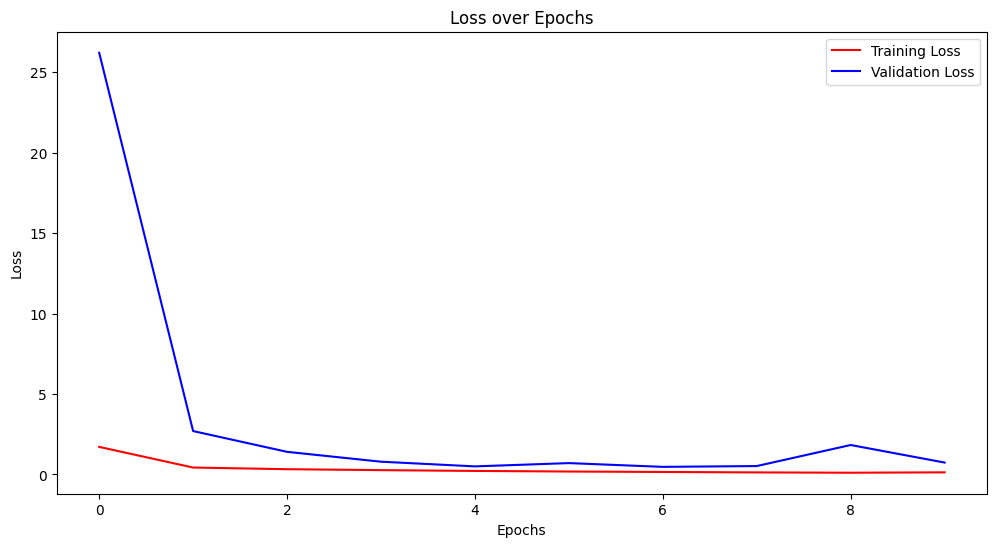

In [37]:
# Calculate F1 scores
f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(precision, recall)]
val_f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(val_precision, val_recall)]

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss', color='red')
plt.plot(val_loss, label='Validation Loss', color='blue')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




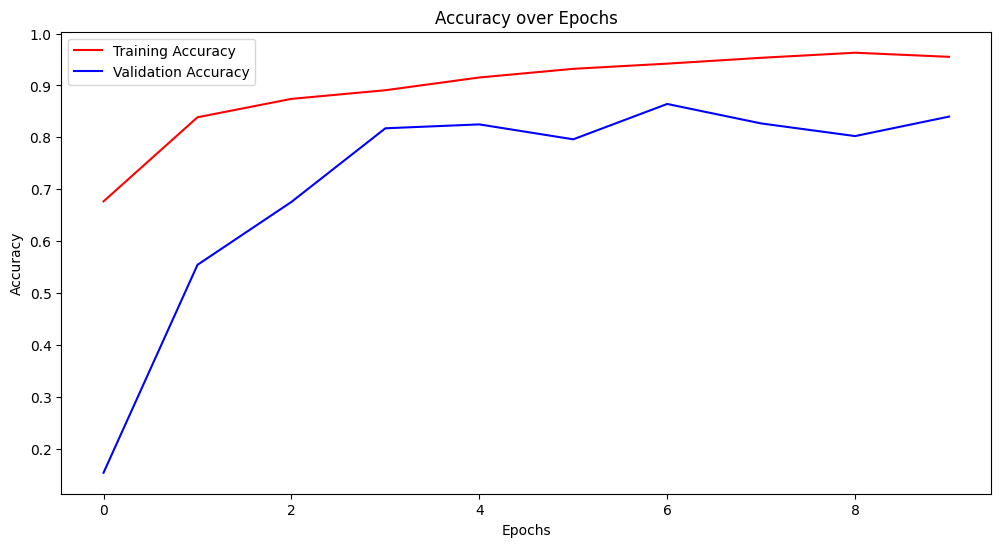

In [38]:
# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(accuracy, label='Training Accuracy', color='red')
plt.plot(val_accuracy, label='Validation Accuracy', color='blue')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



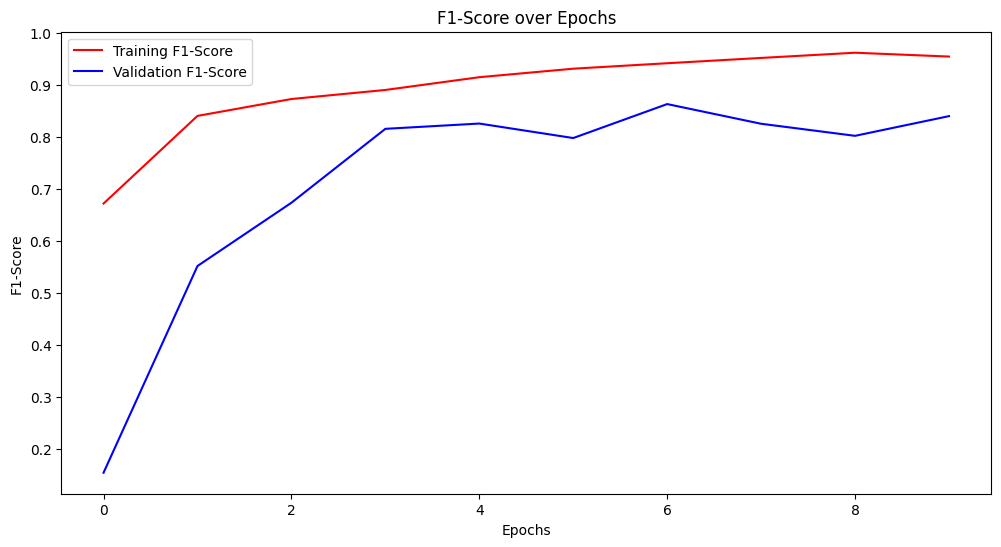

In [39]:
# Plot F1 Score
plt.figure(figsize=(12, 6))
plt.plot(f1, label='Training F1-Score', color='red')
plt.plot(val_f1, label='Validation F1-Score', color='blue')
plt.title('F1-Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

In [13]:
from tensorflow.keras.models import load_model

# Evaluate on test data
true_labels = []
predicted_labels = []
model=load_model('100epwithearlystopping.h5')
for images, labels in test_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Test Accuracy: 0.98


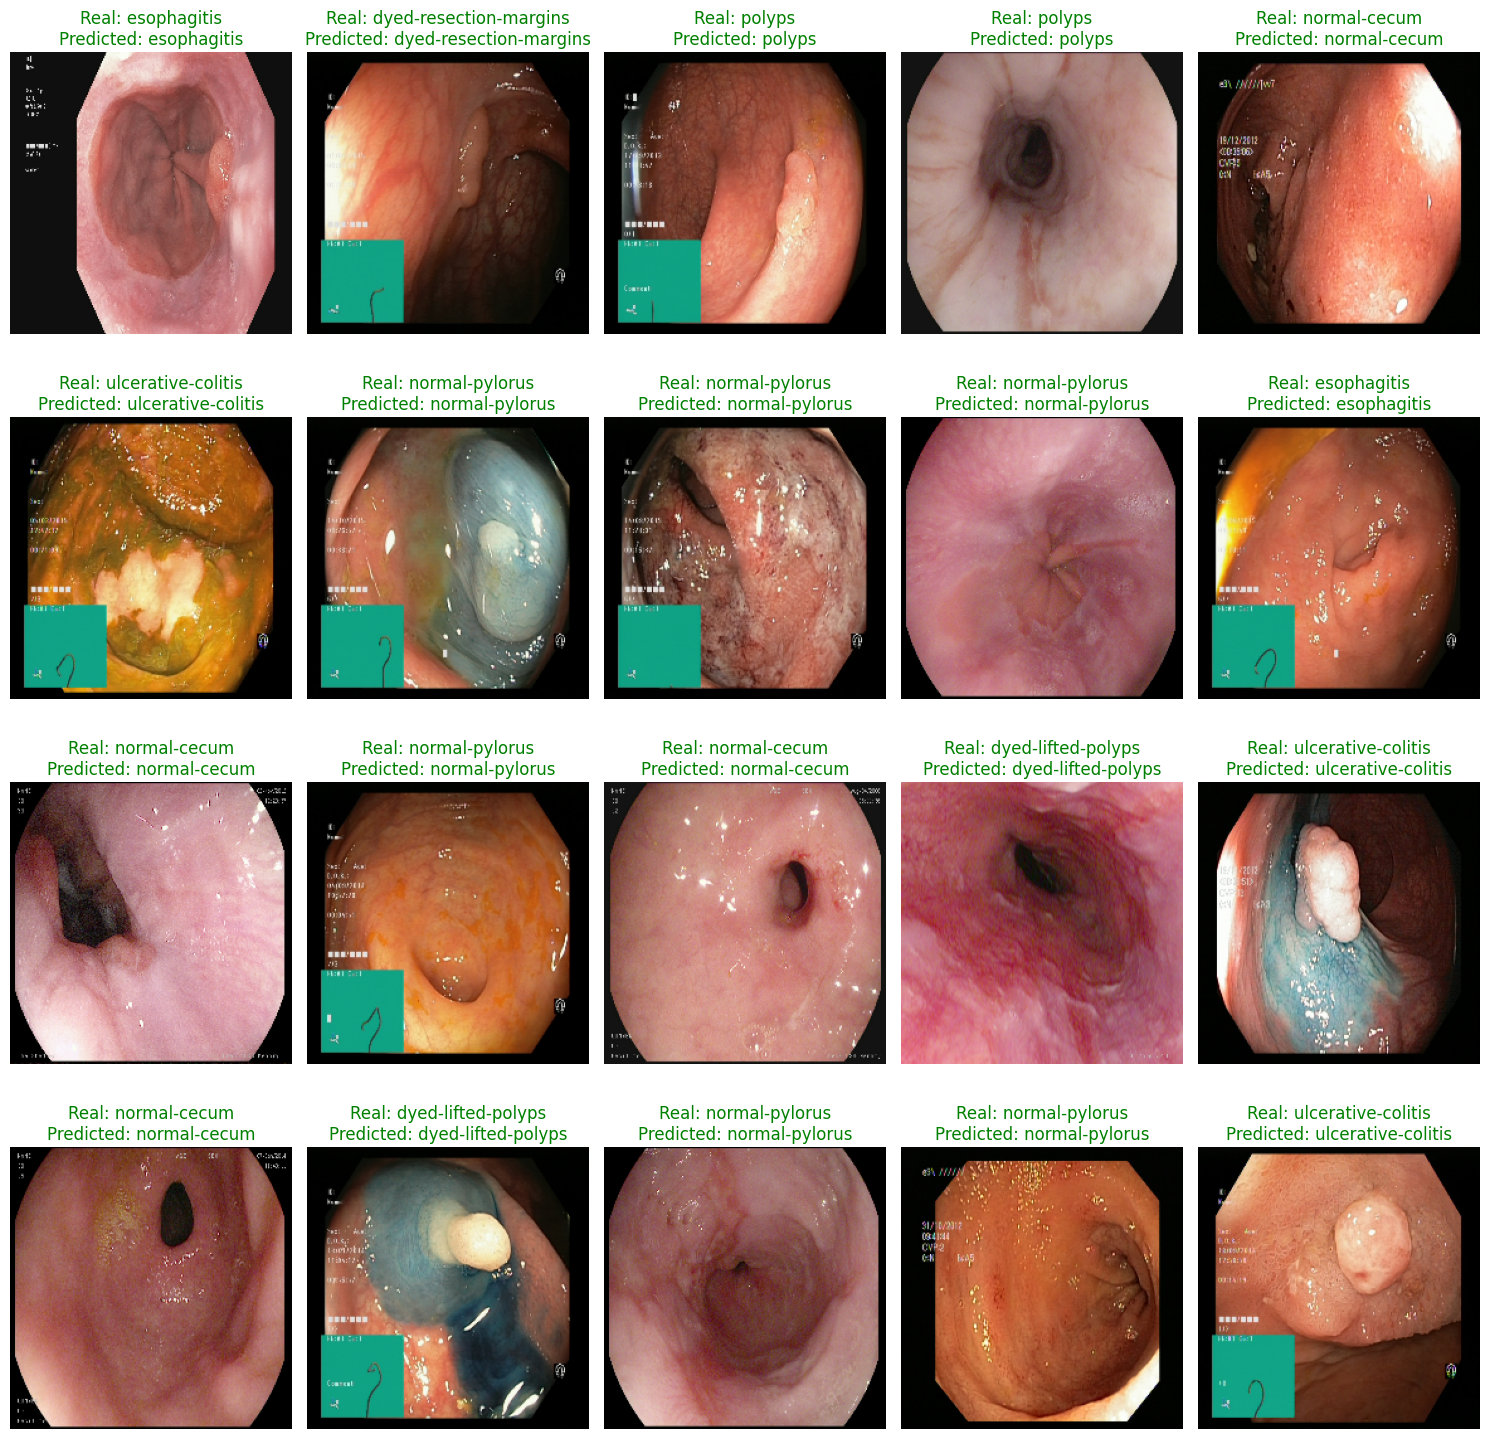

In [14]:
import random
import os

# Convert test_ds to a list of images and labels
class_names = sorted(os.listdir(dataset_path))  # List of class directories

# Convert test_ds to a list of images and labels
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.extend(images.numpy())
    test_labels.extend(labels.numpy())

# Convert to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Select 30 random indices from the test dataset
num_images_to_display = 20
random_indices = random.sample(range(len(true_labels)), num_images_to_display)

# Display the real and predicted labels for the selected images
plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)  # 6 rows, 5 columns
    plt.imshow(test_images[idx].astype("uint8"))  # Display the image

    # Get the real and predicted class names
    real_class = class_names[true_labels[idx]]
    predicted_class = class_names[predicted_labels[idx]]

    # Set title color based on prediction accuracy
    if true_labels[idx] == predicted_labels[idx]:
        title_color = 'green'  # Correct prediction
    else:
        title_color = 'red'    # Incorrect prediction

    plt.title(f"Real: {real_class}\nPredicted: {predicted_class}", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

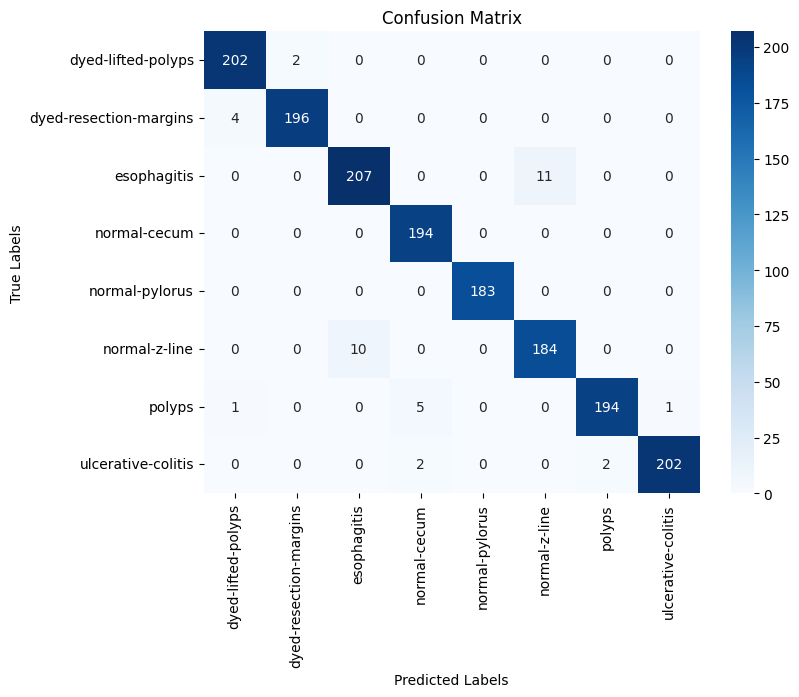


Classification Report:
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.98      0.99      0.98       204
dyed-resection-margins       0.99      0.98      0.98       200
           esophagitis       0.95      0.95      0.95       218
          normal-cecum       0.97      1.00      0.98       194
        normal-pylorus       1.00      1.00      1.00       183
         normal-z-line       0.94      0.95      0.95       194
                polyps       0.99      0.97      0.98       201
    ulcerative-colitis       1.00      0.98      0.99       206

              accuracy                           0.98      1600
             macro avg       0.98      0.98      0.98      1600
          weighted avg       0.98      0.98      0.98      1600



In [15]:

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Softmax Probabilities for 8 Classes:
dyed-lifted-polyps: 0.1029
dyed-resection-margins: 0.1029
esophagitis: 0.1029
normal-cecum: 0.1029
normal-pylorus: 0.1029
normal-z-line: 0.2797
polyps: 0.1029
ulcerative-colitis: 0.1029
Predicted Class: normal-z-line


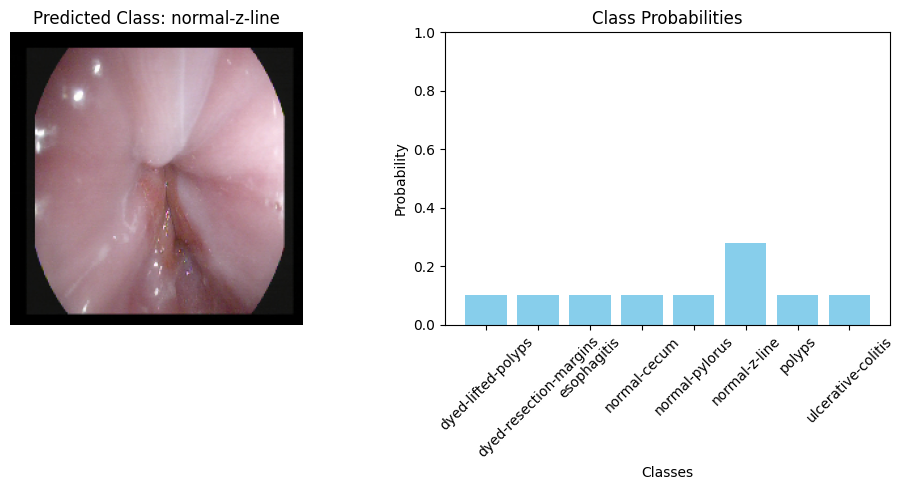

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def preprocess_image(image_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    # img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(img, axis=0)

# Test image path (replace with an actual image path from your dataset)
test_image_path = './unsplit-dataset/normal-z-line/03be9506-bf4a-42e5-b18b-ec8388860fae.jpg'  # Example

# Preprocess the test image
test_image = preprocess_image(test_image_path)

# Predict logits from the model
logits = model.predict(test_image)

# Apply Softmax to get probabilities
softmax_values = tf.nn.softmax(logits[0]).numpy()

# Display class probabilities
print("Softmax Probabilities for 8 Classes:")
for class_name, prob in zip(class_names, softmax_values):
    print(f"{class_name}: {prob:.4f}")

# Get the predicted class
predicted_class = class_names[np.argmax(softmax_values)]
print(f"Predicted Class: {predicted_class}")

# Plot the image and the softmax probabilities
plt.figure(figsize=(10, 5))

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(test_image[0])  # Remove the batch dimension
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')

# Display the softmax probabilities as a bar graph
plt.subplot(1, 2, 2)
plt.bar(class_names, softmax_values, color='skyblue')
plt.title('Class Probabilities')
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]

# Show the plot
plt.tight_layout()
plt.show()

In [21]:
# Overall analysis

# Extract metrics from the training history
metrics = model.history

# Training and validation metrics
loss = metrics['loss']
val_loss = metrics['val_loss']
accuracy = metrics['accuracy']
val_accuracy = metrics['val_accuracy']
precision = metrics['precision']
val_precision = metrics['val_precision']
recall = metrics['recall']
val_recall = metrics['val_recall']

# Calculate F1-Score for Training and Validation
f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(precision, recall)]
val_f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(val_precision, val_recall)]

# Create a figure for overall performance
plt.figure(figsize=(15, 10))

# Subplot 1: Loss
plt.subplot(2, 2, 1)
plt.plot(loss, label='Training Loss', color='red')
plt.plot(val_loss, label='Validation Loss', color='blue')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Subplot 2: Accuracy
plt.subplot(2, 2, 2)
plt.plot(accuracy, label='Training Accuracy', color='red')
plt.plot(val_accuracy, label='Validation Accuracy', color='blue')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Subplot 3: F1-Score
plt.subplot(2, 2, 3)
plt.plot(f1, label='Training F1-Score', color='red')
plt.plot(val_f1, label='Validation F1-Score', color='blue')
plt.title('F1-Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.grid()

# Subplot 4: Precision and Recall
plt.subplot(2, 2, 4)
plt.plot(precision, label='Training Precision', color='orange')
plt.plot(val_precision, label='Validation Precision', color='cyan')
plt.plot(recall, label='Training Recall', color='purple')
plt.plot(val_recall, label='Validation Recall', color='green')
plt.title('Precision and Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid()

# Adjust layout
plt.tight_layout()
plt.show()


TypeError: 'History' object is not subscriptable

In [ ]:
import pandas as pd
import numpy as np
import os

# Assuming the feature files are in a directory and named similarly to the images
feature_dir = 'kvasir-dataset-v2-features'
image_dir = 'unsplit-dataset'
image_labels = []  # List to hold labels
features = []      # List to hold features

# Load features and labels
for filename in os.listdir(feature_dir):
    if filename.endswith('.feature'):
        # Load the feature data (assuming it's in a suitable format)
        feature_path = os.path.join(feature_dir, filename)
        feature_data = np.loadtxt(feature_path)  # Adjust based on actual format

        # Assuming the corresponding image filename is the same (without extension)
        image_name = filename.replace('.feature', '.jpg')  # Adjust extension as needed
        image_path = os.path.join(image_dir, image_name)

        # Load the label (you may have a separate labels file or derive it from the filename)
        label = get_label_from_filename(image_name)  # Implement this function based on your labeling scheme

        features.append(feature_data)
        image_labels.append(label)

# Convert to DataFrame
features_df = pd.DataFrame(features)
labels_df = pd.Series(image_labels)

# Combine features and labels
dataset = pd.concat([features_df, labels_df], axis=1)

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X = dataset.iloc[:, :-1]  # Features
y = dataset.iloc[:, -1]   # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now you can train your model using X_train and y_train